## Import Appropriate Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

## Read in Data

In [2]:
data = pd.read_csv('./data/data_for_clustering.csv')

In [3]:
data.set_index('county', inplace=True)

In [4]:
data.drop(columns=['all_industries', 'Unnamed: 0'], inplace=True)

In [5]:
features = ['nat_resource_mining',
            'construction',
            'manufacturing',
            'trade_trans_util',
            'information',
            'financial',
            'prof_bus_services', 
            'education_health', 
            'leisure_hospitality',
            'government',
            'housing_units',
            'highway_miles',
            'lane_miles',
            'hospitals']

## Tranform All Object Data Types to Numeric By Removing Commas 

In [6]:
objects = ['number of claims_irma',
           'closed claims (paid)_irma',
           'closed claims (not paid)_irma',
           'number claims open_irma',
           'number of claims_michael',
           'closed claims (paid)_michael',
           'closed claims (not paid)_michael',
           'number claims open_michael']

for column in objects:
    data[column] = data[column].map(lambda x: x.replace(',', '')).astype(int)

## Check the Correlation Between Features

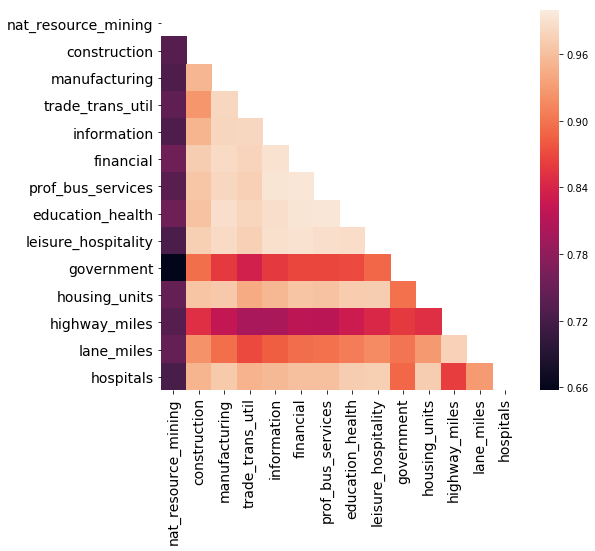

In [7]:
# Generate a mask for the upper triangle (taken from Seaborn example gallery).
mask = np.zeros_like(data[features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True         # triu: TRIangle upper.

fig, ax = plt.subplots(figsize=(8,7))

# Plot the heat map with Seaborn.
# Assign the Matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(data[features].corr(), mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

# If you put plt.show() at the bottom, it prevents useless printouts from Matplotlib.
plt.show();


## Split Data into Train/Test Sets and Use PCA for Dimensionality Reduction

In [8]:
X = data[features]
y = data['number of claims_irma']

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [11]:
pca = PCA(n_components=5)
pca = pca.fit(X_train)

In [12]:
Z_train = pca.transform(X_train)

In [13]:
Z_test = pca.transform(X_test)

In [14]:
# Examine explained variance.
var_exp = pca.explained_variance_ratio_
print('Explained variance:            ', np.round(var_exp,3))

# Examine cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [1. 0. 0. 0. 0.]
Cumulative explained variance:  [0.99988503 0.99998081 0.99999463 0.99999731 0.99999869]


## Visualize the Components
    
* Plot Shows that it is not necessary to use more than two principle components

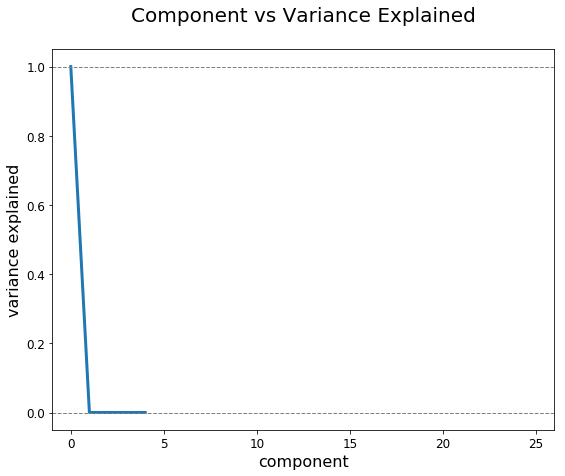

In [15]:
plt.figure(figsize=(9,7))


# Plot the explained variance
component_number = range(len(var_exp))
plt.plot(component_number, var_exp, lw=3)


# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([-1,26])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('Component vs Variance Explained\n', fontsize=20)

plt.show()

## Evalute Linear Regression Results

- $R^2$ Score Not Very Good on Original Test Data
- Higher with PCA Components but Still Underfit and Not Very Useful

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
lm = LinearRegression()

Cross validation scores are all over the map

In [21]:
cv_scores = cross_val_score(lm, X_train, y_train, cv=5)
display(cv_scores)
display(cv_scores.mean())

array([ 0.74423585,  0.78039611, -4.40229984, -0.14543694,  0.15082798])

-0.5744553675034574

In [22]:
lm.fit(X_train, y_train)
lm.score(X_test, y_test)

0.17804060412146683

In [23]:
lm = LinearRegression()

In [26]:
cv_scores = cross_val_score(lm, Z_train, y_train, cv=5)
display(cv_scores)
display(cv_scores.mean())

array([ 0.69229912,  0.89109246, -0.93657635,  0.38517408,  0.41179724])

0.28875730783475034

In [27]:
lm.fit(Z_train, y_train)
lm.score(Z_test, y_test)

0.750074069372933

In [29]:
pca = PCA(n_components=2)

pca = pca.fit(X_train)

In [30]:
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

lm = LinearRegression()

In [32]:
cv_scores = cross_val_score(lm, Z_train, y_train, cv=5)
display(cv_scores)
display(cv_scores.mean())

array([ 0.76257758,  0.86227539, -1.28431379,  0.31821662,  0.20496596])

0.1727443502639733

In [33]:
lm.fit(Z_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Underfit on the Training Data

In [34]:
lm.score(Z_train, y_train)

0.6273225410289492

In [35]:
lm.score(Z_test, y_test)

0.9043606495675532

In [36]:
X_test = X_test.copy()
X_test['predicted claims'] = lm.predict(Z_test)

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, X_test['predicted claims']))

In [39]:
rmse

7120.515613441171

## Get Predicted and True Claims Totals Together Side by Side
    
    - Predictions not too far off in Flager, Clay, Broward, Desoto, and Sumter counties
    - Very far off for other counties
    - This is not a useful model, because it is not complex enough

In [40]:
preds_df = pd.DataFrame(columns=['predicted_claims', 'true_claims'], index=X_test.index)
preds_df['predicted_claims'] = X_test['predicted claims'].round(0)
preds_df['true_claims'] = y_test

In [41]:
preds_df

,predicted_claims,true_claims
county,,
levy,3390.0,585
flagler,6041.0,6749
brevard,27099.0,46883
clay,8705.0,9394
okaloosa,10746.0,266
marion,16475.0,10016
taylor,2609.0,131
broward,89741.0,84042
wakulla,2745.0,105
